# Kaggle2 - ASCII Sign Language


Le but de la compétition est de développer un algorithme ML pour reconnaître les différentes lettres du langage des signes ASL à partir d'images de mains. On dispose d'un jeu de données MNIST ASL donnant pour chaque exemple son label (une lettre de A à Z représentée par un chiffre de 0 à 25) et 784 valeurs de pixels (représentant les 784 pixels de l'image du signe, de taille 28*28, en noir et blanc). Nous devons implémenter un modèle de forêts aléatoires à partir des librairies Numpy et Pandas de Python, puis tester un modèle CNN et d'autres modèles pour tenter d'améliorer la performance de notre classifieur.

# I- Preparation des données
Nous allons commencer par charger les données (entrainement + test) et séparer les données d'entrainement en ensemble d'entrainement/et de validation.

## I.1 - Importation des données

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
# connect to google colab directory where input data is saved
from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
import shutil
folder = "/content/gdrive/My Drive/Colab Notebooks/IFT6390/Kaggle2/" #@param {type:"string"}
os.chdir(folder)

#Training and test sets
#load data in pd

df = pd.read_csv('sign_mnist_train.csv')
dt = pd.read_csv('test.csv')
print(list(df))

print(df.shape)
print(dt.shape)

Mounted at /content/gdrive
['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pix

In [3]:
dx = df.drop(columns = 'label')
dy = df['label']
dtest = dt.drop(columns = 'id')
print(dx.shape, dy.shape,dtest.shape)


(27455, 784) (27455,) (3000, 1568)


## I.2 - Entrainement versus Validation

Nous créons ensuite une fonction traintest qui permet de séparer les données en 2 ensembles : entrainement et validation

In [5]:
#split train dataset  into features and label
def traintest(x,y, prop, rndseed = 12):
# cette fonction prend en entrée :
# x: un dataframe contenant les attributs des inputs
# y: un dataframe contenant les labels des inputs
# prop: Le % des données d'entrée à utiliser pour l'entrainement
# rndseed : random seed

  #split train dataset into train/validation
  split = prop
  n = x.shape[0]
  n_train = np.int32(n * split)
  np.random.seed(rndseed)
  idx = list(range(n))
  np.random.shuffle(idx)
  train_idx = idx[:n_train]
  val_idx = idx[n_train:]
  x_train = np.array(x)[train_idx,:]
  y_train = np.array(y)[train_idx]
  x_val = np.array(x)[val_idx,:]
  y_val = np.array(y)[val_idx]
  return (x_train, y_train, x_val, y_val)


In [4]:
x_train, y_train, x_val, y_val = traintest(dx, dy, 0.8, 12)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(21964, 784) (21964,) (5491, 784) (5491,)


## I.3 - Fonctions auxiliaires

Nous allons aussi créer quelques fonctions support pour transformer l'ensemble de test - qui contient 2 images par lignes initialement - en une seule image par ligne, et pour préparer le fichier de prédictions de test selon les instructions : conversion des 2 lettres prédites en ASCII, somme des 2 nombres ASCII, soustraction de 65, puis reconversion en caractère.

In [6]:
#visualize one image in dataset
def viewimage(x, ind):
  image = x[ind].reshape(28,28)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.show()

In [7]:
#split test dataset into 2 examples
def prepare_test(test):
  test = np.array(test)
 # print(test.shape, test[0], test[2999])
  ex1 = test[:,:784]
  ex2 = test[:,784:]
 # print(ex1.shape, ex2.shape)
  return np.concatenate([ex1,ex2],axis = 0)


#prepare output from predictions
def prepare_output(test):
  n = np.int32(test.shape[0] / 2)
  ex1 = test[:n]
  ex2 = test[n:]
  print(ex1.shape, ex2.shape)
  #ascii add 65 to predicted label to get ASCII - sum the 2 numbers (min = 130 - max = 180).  decrease result by 65 to get an ascii number between 65 and 122- convert into character.
  asc1 = ex1+ex2 + 65
  print(asc1)
  charac = np.array([chr(x) for x in range(122)])[asc1]
  return (charac.astype('str'))

def export_output(pred, filename):
   # index = [str(i) for i in range(1, len(pred)+1)]
    output = pd.DataFrame(pred,columns = ['label'])
    output.index.name = 'id'
    #print(output)
    output.to_csv(filename)

In [8]:
#Normalize input data
def normalize(x):
  a = np.array(x)
  mu = np.mean(a, axis = 0)
  sigma = np.std(a, axis=0)
  return (a - mu)/sigma

##I.4 - Augmentation des données

La fonction ci-dessous crée de nouvelles images à partir des données d'entrée, en appliquant des transformations aléatoires (rotations, zoom-in et zoom-out, bruit gaussien). D'autres transformations ont été testées (horizontal flip, contrast) mais n'ont pas été retenues au final car ne semblaient pas améliorer la précision du modèle.

In [9]:
# Transform images
from torchvision import transforms
from torchvision.transforms import v2
import torch
def augment(x):

#padding  (testé mais non retenu au final, car n'améliorait pas la précision sur l'ens de validation)
  pad = v2.Pad(padding=3)
#contrast (testé mais non retenu au final, car n'améliorait pas la précision sur l'ens de validation)
  con = v2.ColorJitter(brightness=.5, hue=.3)
#rotation
  rotate = v2.RandomRotation(degrees=(-10, 10))
#gaussian blur
  blur = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
#horizontal flip (testé mais non retenu au final, car n'améliorait pas la précision sur l'ens de validation)
  hflip = v2.RandomHorizontalFlip(p=1.)
#zoom in/out
  zoom = v2.CenterCrop(24)
  #resize()
  res =v2.Resize(28)
  zoomout = v2.CenterCrop(28)
  #resize()
  res2 =v2.Resize(24)
# non retenus:
  x_hf = hflip(x)
  x_con = con(x)
# retenus:
  x_zoom = res(zoom(x))
  x_zout = zoomout(res2(x))
  x_rot = rotate(x)
  x_blur = blur(x)
  all_x = torch.cat((x, x_rot,  x_zoom, x_zout,x_blur), 0)

  return (all_x)

In [9]:
#Normalize train and test data
x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(dtest)
print(x_train.shape, x_val.shape, x_test.shape)

(21964, 784) (5491, 784) (3000, 1568)


In [10]:
#augment data
x_aug = augment(torch.from_numpy(x_train.reshape(-1,1,28,28)).float())
y_aug = np.concatenate([y_train, y_train,y_train, y_train, y_train], axis= 0)
print(y_aug.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(109820,)


image originale: 


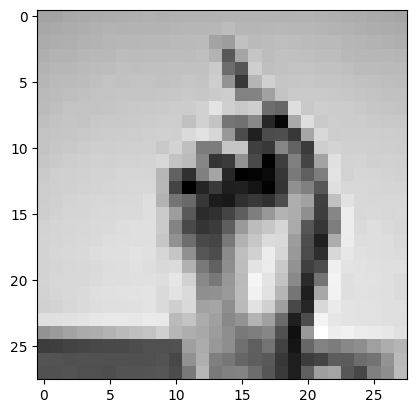

In [ ]:
#visualisons un exemple d'image originale et ses différentes transformations
print('image originale: ')
viewimage(x_aug,21964*0+1)


rotation +/- 10 degrés: 


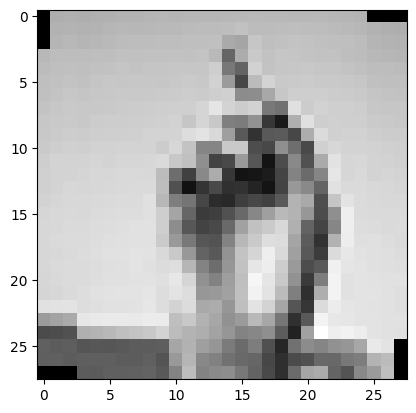

In [ ]:
print('rotation +/- 10 degrés: ')
viewimage(x_aug,21964*1+1)


zoom in: 


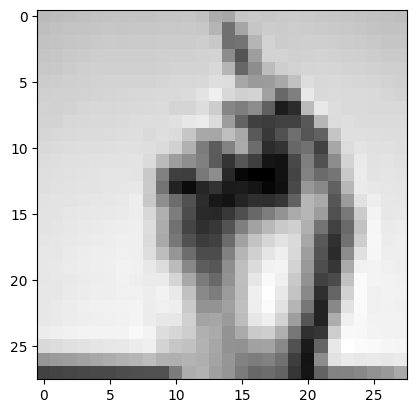

In [ ]:
print('zoom in: ')
viewimage(x_aug,21964*2+1)


zoom out: 


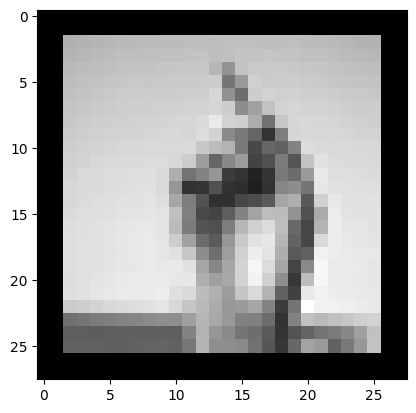

In [ ]:
print('zoom out: ')
viewimage(x_aug,21964*3+1)

Gaussian blurr: 


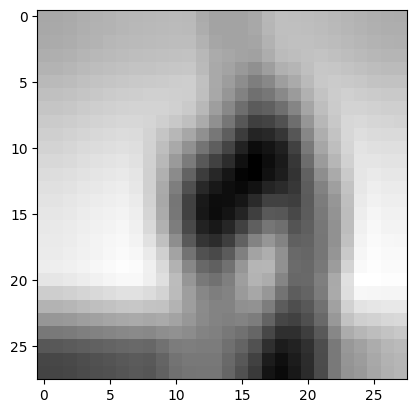

In [ ]:
print('Gaussian blurr: ')
viewimage(x_aug,21964*4+1)

# II - Forêts aléatoires


## II.1 - Arbre de décision

Commençons par implémenter un modèle d'arbre de décision et quelques fonctions auxiliaires

In [13]:
from collections import Counter

def get_majority_class(labels):
    #retourne le label le plus fréquent dans le tableau d'entrée.
    counts = Counter(labels)
    return counts.most_common(1)[0][0]

def compute_entropy(labels):
    # Cette fonction calcule l'entropie
    # (= sum_l(-p_l log2 (p_l)) pour chaque label l)
    # du tableau d'entrée

    counts = Counter(labels)
    counts = np.array([counts[key] for key in counts])
    freq = counts/counts.sum()
    entropy = -(freq*np.log2(freq)).sum()
    return entropy



Implémentons une classe **Node** (noeud) à utiliser dans l'arbre de décision. Un noeud dans l'arbre peut:

* poser une question (= determiner si les exemples ont un certain attribut plus grand qu'un certain seuil),
* trouver la meilleure question pour séparer un (sous-ensemble d'un) jeu de données, ou
* si c'est une feuille, faire une prédiction

Pour trouver la meilleure question pour un attribut, calculer tout les **valeurs intermédiaires** de cet attribut, et pour chaque valeur intermédiaire, calculer l'entropie de la séparation obtenue quand la question utilise cette valeur intermédiaire. Pour trouver la meilleur question, répeter ça pour chaque colonne, et choisir la meilleur question.


In [14]:
class Node():
    def __init__(self):
        self.threshold = None # le seuil du test
        self.col = None # valeur de l'index de l'attribut étudié
        self.is_leaf = None
        self.output_class = None
        self.left_child=None # les nouveaux sous arbres - pointeurs vers le prochain element un peu comme les listes chainées
        self.right_child=None

    def find_best_question(self, x, y):
        # x: tableau numpy de dimension (nombre d'exemples, nombre d'attributs)
        # y: tableau numpy de dimension (nombre d'exemples,)
        best_col = 0
        best_val = 0
        best_loss = np.inf

        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols) # nb of features
        for col in valid_cols:
            #
            # Calculer les valeurs intermédiaires de cette colonne
            #
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i]+sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1)] # list de seuils potentiels

            for val in midpoints:
                # En utilisant col et val, séparer les labels
                # en left_labels (labels_gauches) et right_labels
                # (labels_droits)
                right_subset_rows = x[: , col] > val # masque pour filtrer les points au dessus du seuil
                left_subset_rows = np.invert(right_subset_rows) #masque complémentaire

                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]

                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)

                p_right = len(right_labels)/len(y)
                p_left = len(left_labels)/len(y)


                loss =  p_left*left_entropy + p_right*right_entropy # entropie conditionnelle


                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue

                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val

        self.col = best_col
        self.threshold = best_val

    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False

    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None


Maintenant, en utilisant la classe Node, nous allons implémenter l'arbre de décision. Comme avec l'interface de scikit-learn, nous aurons les méthodes fit() et predict().

In [15]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth # pour éviter overfitting

    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()

        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)

        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset,y_subset)#split optimal
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset) #jeu de données splitté selon le split optimal - droite
            left_subset_rows = np.invert(right_subset_rows) #gauche
            #
            # Boucle récursive: créer node.left_child (enfant gauche du noeud) et
            # node.right_child (enfant droit du noeud)
            #
            node.left_child = self.create_node(x_subset[left_subset_rows],y_subset[left_subset_rows],depth+1) # appel récursif sur le sous-ens de gauche, avec depth +1
            node.right_child = self.create_node(x_subset[right_subset_rows],y_subset[right_subset_rows], depth+1) # idem a droite

        return node

    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)

    def predict(self, x): #on fait passer le point à travers l'arbre
        predictions = []

        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True

                else:
                    if current_node.ask_question(x_i): #regarde d'un coté
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)


## II.2 - Forêt aléatoire
Implémentons ensuite une forêt aléatoire en utilisant notre arbre de décision. (on prendra en fait l'implémentation ScikitLearn de l'arbre de decision car notre implémentation est trop lente)

Une forêt aléatoire est un ensemble d'arbres de décision, où chaque arbre est entrainé sur une variation aléatoire du jeu de données.  

Nous implémentons deux façons d'obtenir des variations aléatoires du jeu de données:

1) La sélection aléatoire d'attributs (feature bagging): entrainer chaque arbre de décision sur un sous-ensemble aléatoire des attributs du jeu de données initial.

2) Bootstrapping (example bagging): entrainer chaque arbre de décision sur un sous-ensemble aléatoire du jeu de données obtenu par bootstrapping.

In [16]:
import math
# nous utiliserons l'implementation ScikitLearn de l'arbre de décision
#car l'implémentation numpy est trop lente
from sklearn.tree import DecisionTreeClassifier

class RandomForestClassifier():
    def __init__(self, n_estimators=2, max_depth=5, bootstrap_fraction=0.5, features_fraction=0.5):
        self.max_depth = max_depth
        self.n_estimators = n_estimators #nombre d'arbres qu'on va utiliser
        self.bootstrap_fraction = bootstrap_fraction # nb de données choisies avec remplacement dans chaque arbre
        self.features_fraction= features_fraction #nombres de features choisis aléatoirement dans chq arbre
        self.estimators = []

    def fit(self, x, y):
        num_rows = math.ceil(self.bootstrap_fraction * x.shape[0])
        num_cols = math.ceil(self.features_fraction * x.shape[1])
        for _ in range(self.n_estimators):
            # les sous-ensembles aléatoires x_subset, y_subset

            rows_idx = np.random.choice(x.shape[0], size = num_rows)
            cols_idx = np.random.choice(x.shape[1], size = num_cols, replace = False)
            x_subset = x[rows_idx][:, cols_idx]
            y_subset = y[rows_idx]

            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x_subset, y_subset)
            self.estimators.append((tree,cols_idx)) # on renvoie un tuple avec un arbre et le masque des attributs correspondants

    def predict(self, x):
        allpreds = np.array([e.predict(x[:,cols]) for e, cols in self.estimators])
        predictions = np.array([get_majority_class(y) for y in allpreds.T])
        return predictions


## II.3 - Analyse des hyper-paramètres


Analysons la sensibilité du modèle de forêts aléatoires par rapport à ses principaux hyperparamètres. D'abord, traçons les performances en fonction du nombre d'arbres dans la forêt aléatoire en utilisant une taille d'arbre maximale de 5, et des paramètres de bootstrapping et de sélection de features de 50%.


nestimator =  0.2722637042433072
nestimator =  0.36878528501183755
nestimator =  0.4037515935166636
nestimator =  0.4155891458750683
nestimator =  0.4064833363686032
nestimator =  0.4179566563467492
nestimator =  0.42942997632489527
nestimator =  0.3875432525951557
nestimator =  0.4197778182480423
nestimator =  0.4095793116008013
Best performance:  0.42942997632489527


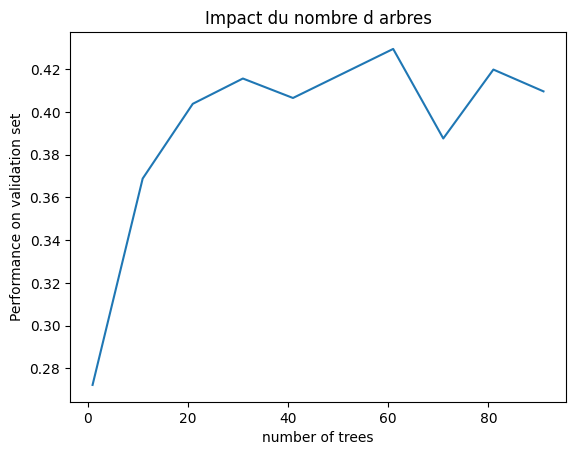

In [ ]:
tree_counts = []
accuracies = []
for tree_count in range(1,100, 10):

    model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=5,
                                   bootstrap_fraction=0.5,
                                   features_fraction=0.5)
    model.fit(x_train, y_train)
    accuracy = (model.predict(x_val) == y_val).mean()
    accuracies.append(accuracy)
    tree_counts.append(tree_count)
    print('nestimator = ', accuracy )
print("Best performance: ", max(accuracies))
plt.title('Impact du nombre d arbres')
plt.xlabel('number of trees')
plt.ylabel('Performance on validation set')
plt.plot(tree_counts, accuracies)


Testons ensuite l'impact de la taille maximum des arbres de la forêt aléatoire, en utlisant un nombre d'arbres de 10 et des paramètres de bootstrapping et de sélection de features de 50%.

nestimator =  0.07685303223456565
nestimator =  0.18393735203059552
nestimator =  0.3574940812238208
nestimator =  0.5907849207794573
nestimator =  0.726097250045529
nestimator =  0.8617738116918594
nestimator =  0.923511200145693
nestimator =  0.9413585867783646
nestimator =  0.962666181023493
nestimator =  0.9684938991076306
Best performance:  0.9684938991076306


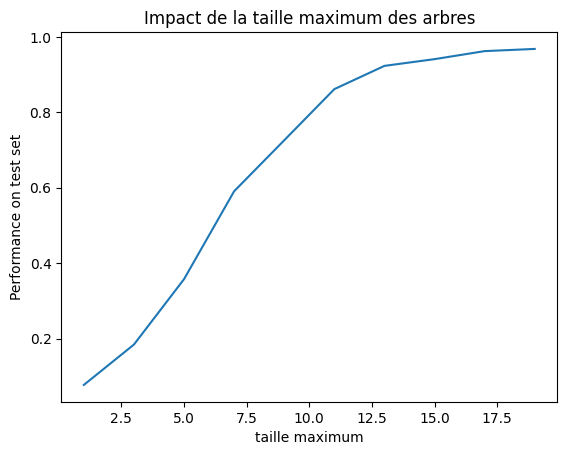

In [17]:
tree_sizes = []
accuracies = []
for tree_size in range(1,20,2):

    model = RandomForestClassifier(n_estimators=10,
                                   max_depth=tree_size,
                                   bootstrap_fraction=0.5,
                                   features_fraction=0.5)
    model.fit(x_train, y_train)
    accuracy = (model.predict(x_val) == y_val).mean()
    accuracies.append(accuracy)
    tree_sizes.append(tree_size)
    print('nestimator = ', accuracy )
print("Best performance: ", max(accuracies))
plt.title('Impact de la taille maximum des arbres')
plt.xlabel('taille maximum')
plt.ylabel('Performance on test set')
plt.plot(tree_sizes, accuracies)


Testons ensuite l'impact du paramètre de bootstrapping. Les autres hyperparamètres sont fixés à:
 - nombre d'arbres = 20
 - profondeur maximale = 10
 - % de features sélectionnés = 50%

nestimator =  0.7989437260972501
nestimator =  0.8625022764523766
nestimator =  0.8757967583318157
nestimator =  0.8781642688034966
nestimator =  0.8736113640502641
Best performance:  0.8781642688034966


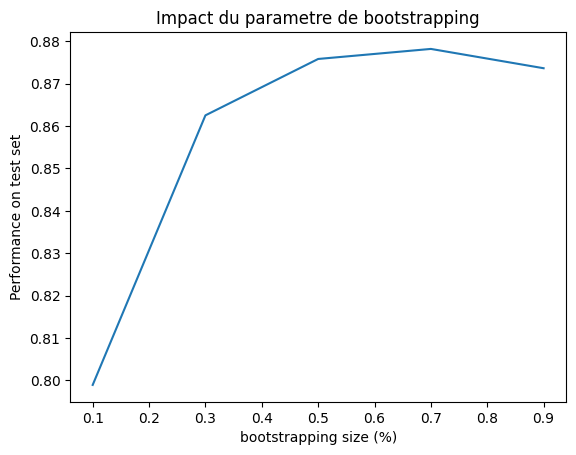

In [ ]:
bootstrap = []
accuracies = []
for b in [0.1,0.3,0.5, 0.7,0.9]:

    model = RandomForestClassifier(n_estimators=20,
                                   max_depth=10,
                                   bootstrap_fraction=b,
                                   features_fraction=0.5)
    model.fit(x_train, y_train)
    accuracy = (model.predict(x_val) == y_val).mean()
    accuracies.append(accuracy)
    bootstrap.append(b)
    print('nestimator = ', accuracy )
print("Best performance: ", max(accuracies))
plt.title('Impact du parametre de bootstrapping')
plt.xlabel('bootstrapping size (%)')
plt.ylabel('Performance on test set')
plt.plot(bootstrap, accuracies)

Testons enfin l'impact du paramètre de % features sélectionnés dans chaque arbre. Les autres hyperparamètres sont fixés à:
 - nombre d'arbres = 20
 - profondeur maximale = 10
 - % de données échantillonnées par bootstrapping = 50%

nestimator =  0.8845383354580222
nestimator =  0.875978874521945
nestimator =  0.8727007830996175
nestimator =  0.8690584592970315
Best performance:  0.8845383354580222


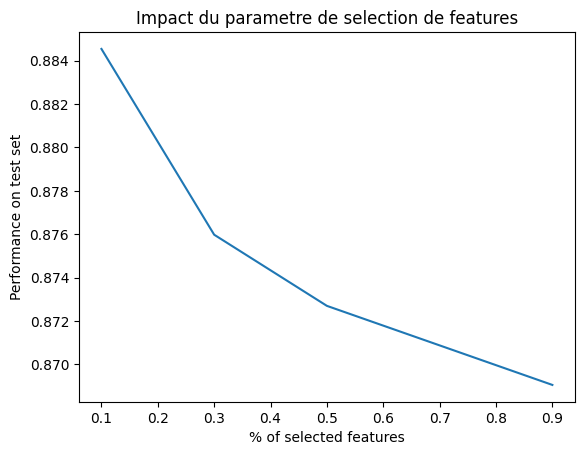

In [ ]:
features = []
accuracies = []
for f in [0.1,0.3,0.5,0.9]:

    model = RandomForestClassifier(n_estimators=20,
                                   max_depth=10,
                                   bootstrap_fraction=0.5,
                                   features_fraction=f)
    model.fit(x_train, y_train)
    accuracy = (model.predict(x_val) == y_val).mean()
    accuracies.append(accuracy)
    features.append(f)
    print('nestimator = ', accuracy )
print("Best performance: ", max(accuracies))
plt.title('Impact du parametre de selection de features')
plt.xlabel('% of selected features')
plt.ylabel('Performance on test set')
plt.plot(features, accuracies)

##II.4 - Evaluation du modèle sélectionné

Evaluons le modèle de forêts aléatoires pour les hyper-paramètres choisis:

- profondeur maximale = 40
- Nombre d'arbres = 50
- proportion de données bootstrappées: 50%
- proportions de features sélectionnés aléatoirement: 50%

In [ ]:
tree_count = 50
max_depth = 40
b = 0.5 # proportion boostrapping
f = 0.5 # proportion features selected
#train_acc = []
#val_acc = []
model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=max_depth,
                                   bootstrap_fraction=b,
                                   features_fraction=f)
#model.fit(xtrain, y_aug)
model.fit(x_train, y_train)
val_accuracy = (model.predict(x_val) == y_val).mean()
accuracy = (model.predict(x_train) == y_train).mean()
#val_acc.append(val_accuracy)
#train_acc.append(accuracy)
print('Train accuracy = ', accuracy )
print("Val accuracy: ", val_accuracy)


In [ ]:
#Testons ce modèle sur les données test
pred = model.predict(prepare_test(normalize(x_test)))
predtest = prepare_output(pred)
#print(predtest)
export_output(predtest,'RForest_40_nb50_0.5_0.5.csv')

## II.5 - Data augmentation

Pour tenter de réduire la variance du classifieur obtenu, ajoutons de nouvelles données en utilisant les transformations suivantes :

- rotations aléatoires = +/- 10 degrés
- zoom in et out
- ajout d'un bruit gaussien

In [ ]:
#augmentation des données
#augment data
x_aug = augment(torch.from_numpy(x_train.reshape(-1,1,28,28)).float())
y_aug = np.concatenate([y_train, y_train,y_train, y_train, y_train], axis= 0)
print(y_aug.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([21964, 1, 28, 28])
torch.Size([21964, 1, 28, 28])
torch.Size([109820, 1, 28, 28])
(109820,)


In [ ]:
# reshape x_aug to a numpy vector (:,784)
xtrain = x_aug.numpy().reshape(-1,784)
print(xtrain.shape)

(109820, 784)


In [ ]:
tree_count = 50
max_depth = 40
b = 0.5 # proportion boostrapping
f = 0.5 # proportion features selected
#train_acc = []
#val_acc = []
model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=max_depth,
                                   bootstrap_fraction=b,
                                   features_fraction=f)
model.fit(xtrain, y_aug)
#model.fit(x_train, y_train)
val_accuracy = (model.predict(x_val) == y_val).mean()
accuracy = (model.predict(xtrain) == y_aug).mean()
#val_acc.append(val_accuracy)
#train_acc.append(accuracy)
print('Train accuracy = ', accuracy )
print("Val accuracy: ", val_accuracy)


Train accuracy =  0.9999271535239482
Val accuracy:  0.9947186304862502


In [ ]:
pred = model.predict(prepare_test(normalize(x_test)))
predtest = prepare_output(pred)
export_output(predtest,'RForest_40_nb50_0.5_0.5_norm_dataaugRot_Blur.csv')

0.9941722819158623
(3000,) (3000,)
[ 90  89  71 ... 110  83  86]
['Z' 'Y' 'G' ... 'n' 'S' 'V']


Examinons quelques exemples de données test et comparons les aux prédictions

10 17
(3000,) (3000,)
[77 89 71 ... 94 83 86]
\ \


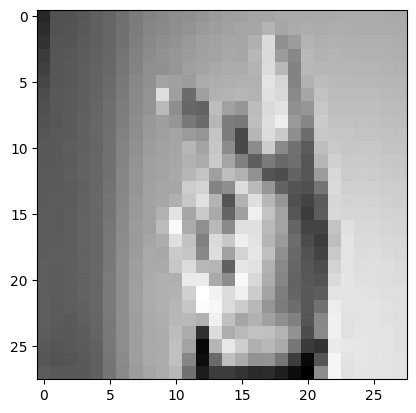

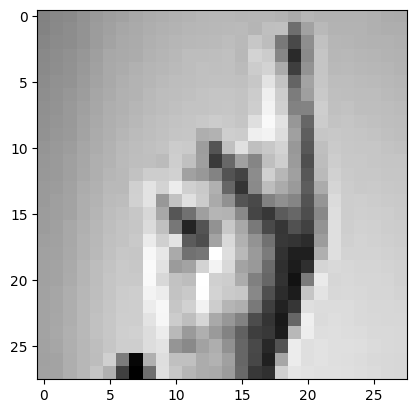

In [ ]:
a = prepare_test(dtest)
ind = 4

print(pred[ind], pred[ind+3000])
print(chr(65+pred[ind]+pred[ind+3000]), prepare_output(pred)[ind])
viewimage(a,ind)
viewimage(a,ind+3000)
#  faux:1,3,5,6,8,9,10,11,12,17.18

Examinons les erreurs commises sur l'ensemble de validation pour quelques images:

[4] [12]


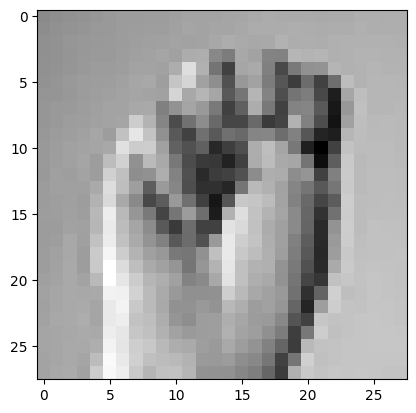

In [ ]:
#images en erreur dans l'ensemble de validation
predval = model.predict(x_val)
index = np.argwhere(predval!=y_val)
ind = index[3]
print(predval[ind], y_val[ind])
viewimage(x_val,ind)


# III - CNN

Pour améliorer la précision de nos prédictions, nous allons tester un modèle CNN, famille de modèles mieux adaptés pour des images. Nous allons commencer par tester un modèle NN pleinement connecté simple, inspiré du modèle de NN vu au lab8, puis comparer sa performance avec un modèle CNN, dont la structure est inspirée du heavy CNN vu au lab9.

## III.1 - NN pleinement connecté



Commençons par tester un modèle de NN pleinement connecté

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda:0')

### Traitement des données ASL


x_train, y_train, x_val, y_val = traintest(dx,dy,0.8,12)
num_train = x_train.shape[0]
num_test = x_val.shape[0]
num_features = x_train.shape[1]
num_classes = 26
x_train = torch.from_numpy(normalize(x_train)).float().to(device)
x_val = torch.from_numpy(normalize(x_val)).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_val = torch.from_numpy(y_val).long().to(device)


In [12]:

### Hyperparamètres & architecture
from torchsummary import summary
model = nn.Sequential(
    nn.Linear(num_features, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, num_classes),
).to(device)

num_epochs = 5000
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
            Linear-3                  [-1, 500]         100,500
              ReLU-4                  [-1, 500]               0
            Linear-5                  [-1, 500]         250,500
              ReLU-6                  [-1, 500]               0
            Linear-7                   [-1, 26]          13,026
Total params: 521,026
Trainable params: 521,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.99
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


In [13]:
### Boucle d'entrainement


losses = []
losses_test = []

for epoch in range(num_epochs):
    if epoch%1000 == 0:
      print('epoch # : ', epoch)
    model.train()
    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses.append(loss.item())
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation à chaque epoch
    model.eval()
    preds_test = model(x_test)
    loss_test = loss_fn(preds_test, y_test)
    losses_test.append(loss_test.item())



epoch # :  0
epoch # :  1000
epoch # :  2000
epoch # :  3000
epoch # :  4000


train accuracy : 0.45365142961209254
test accuracy : 0.4512839191404116


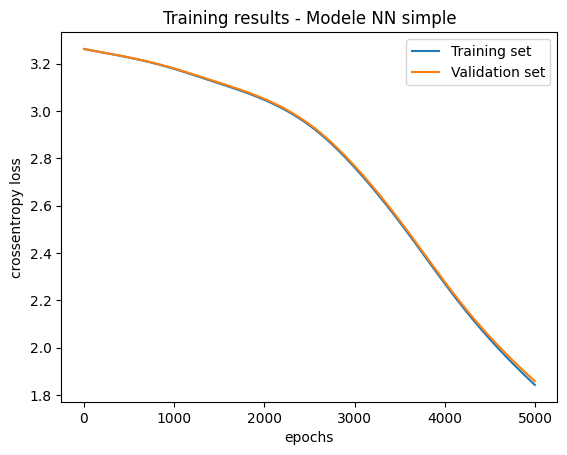

In [14]:

### Résultats

plt.plot(range(num_epochs), losses, label = 'Training set')
plt.plot(range(num_epochs), losses_test, label = 'Validation set')
plt.title('Training results - Modele NN simple')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('crossentropy loss')

preds_train = model(x_train)
acc = 0
for i in range(len(y_train)):
  if torch.argmax(preds_train[i]) == y_train[i]:
    acc += 1
print('train accuracy : {}'.format(acc / len(y_train)))

preds_test = model(x_val)
acc = 0
for i in range(len(y_val)):
  if torch.argmax(preds_test[i]) == y_val[i]:
    acc += 1
print('test accuracy : {}'.format(acc / len(y_val)))

In [ ]:
datatest = torch.from_numpy(normalize(prepare_test(dtest))).float().to(device)
predictions = model(datatest)
preds = torch.argmax(predictions, axis=1)
pred = np.array(preds.cpu())

print(pred)

predtest = prepare_output(pred)
print(predtest)
export_output(predtest,'NN_lab8.csv')

[ 6  2  1 ... 21 14 14]
(3000,) (3000,)
[ 77  90  71 ... 109  83  98]
['M' 'Z' 'G' ... 'm' 'S' 'b']


Analysons quelques exemplaires d'images de test et des prédictions du modèle

5 13
S S


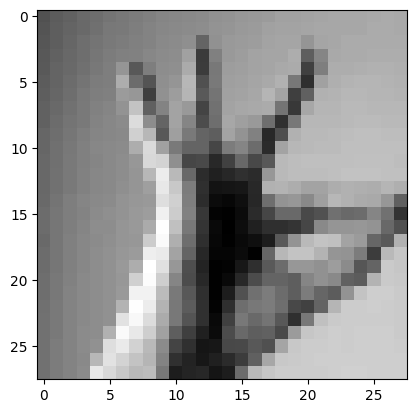

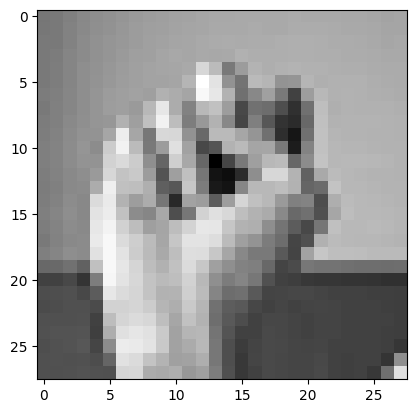

In [ ]:
a = prepare_test(dtest)
ind = 20
print(pred[ind], pred[ind+3000])
print(chr(65+pred[ind]+pred[ind+3000]), predtest[ind])
viewimage(a,ind)
viewimage(a,ind+3000)
#  faux:1,3,5,6,8,9,10,11,12,17.18
#with NN: 4,5,6,7,8,10,11,15,17,18

Impact des hyperparamètres - learning rate

Testons l'impact du LR sur l'apprentissage du modèle

In [ ]:

### Boucle d'entrainement
### Hyperparamètres & architecture


num_epochs = 5000
#learning_rate = 2e-3

losses = np.zeros((num_epochs, 4))
losses_test = np.zeros((num_epochs, 4))

for i, learning_rate in enumerate([0.005, 0.001, 0.0001]):
  print('learning rate tested: ', learning_rate)
  print(i)

  model = nn.Sequential(
    nn.Linear(num_features, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, num_classes),
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  for epoch in range(num_epochs):
    if epoch%1000 == 0:
      print('epoch # : ', epoch)
    optimizer.zero_grad()
    model.train()
    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses[epoch, i] =loss.item()
    #print(loss.item())


    loss.backward()
    optimizer.step()

    # Evaluation à chaque epoch
    model.eval()
    preds_test = model(x_val)
    loss_test = loss_fn(preds_test, y_val)
    losses_test[epoch, i] = loss_test.item()




learning rate tested:  0.005
0
epoch # :  0
epoch # :  1000
epoch # :  2000
epoch # :  3000
epoch # :  4000
learning rate tested:  0.001
1
epoch # :  0
epoch # :  1000
epoch # :  2000
epoch # :  3000
epoch # :  4000
learning rate tested:  0.0001
2
epoch # :  0
epoch # :  1000
epoch # :  2000
epoch # :  3000
epoch # :  4000


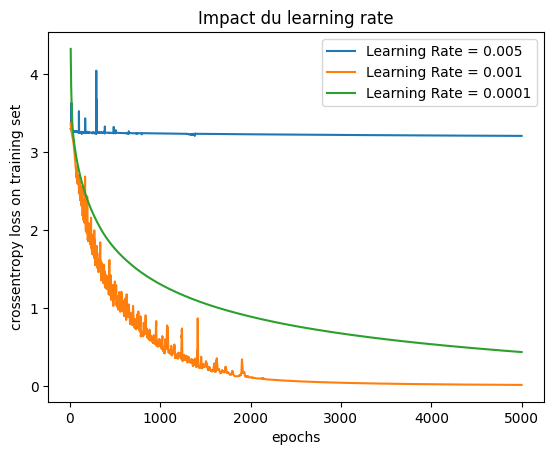

In [ ]:
# impact du learning rate sur l'apprentissage

# Tracons la fonction de perte sur les données d'entrainement
plt.plot(np.arange(num_epochs)[10:], losses[10:,0], label = 'Learning Rate = 0.005')
plt.plot(np.arange(num_epochs)[10:], losses[10:,1], label = 'Learning Rate = 0.001')
plt.plot(np.arange(num_epochs)[10:], losses[10:,2], label = 'Learning Rate = 0.0001')
#plt.plot(np.arange(num_epochs)[1:], losses[1:,3], label = 'Learning Rate = 0.00001')

#plt.plot(range(num_epochs), losses_test)
plt.title('Impact du learning rate')
plt.xlabel('epochs')
plt.ylabel('crossentropy loss on training set')
plt.legend()


## III.2 - CNN

Testons maintenant un modèle CNN, dont la structure est inspirée du heavy CNN vu au lab9, modifiée pour l'adapter au problème de classification du kaggle (26 classes de sorties)

### III.2.1 - Structure du modèle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


torch.manual_seed(12)
torch.cuda.manual_seed(12)
device = torch.device('cuda:0')

### Traitement des données ASL
x_train, y_train, x_val, y_val = traintest(dx, dy, 0.8, 12)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

num_train = x_train.shape[0]
num_test = x_val.shape[0]
num_features = x_train.shape[1]
num_classes = 26

x_train = torch.from_numpy(x_train.reshape(-1,1,28,28)).float().to(device)
x_test = torch.from_numpy(x_val.reshape(-1,1,28,28)).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_val).long().to(device)

### Hyperparamètres & architecture

model = nn.Sequential(
        nn.Conv2d(1,32,3,padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32,32,3,padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32,64,3,padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3,padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        #fully connected layer for readou
        nn.Linear(64*7*7,512),
        nn.BatchNorm1d(512),
        nn.Dropout(0.2),
        nn.Linear(512,26)
        ).to(device)
summary(model, (1,28,28))

(21964, 784) (21964,) (5491, 784) (5491,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]              

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0], batchsize):
        end_idx = min(start_idx + batchsize, inputs.shape[0])
        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]

### III.2.2 Hyper-paramètres

Testons d'abord l'impact du learning rate sur l'apprentissage du modèle

In [ ]:

num_epochs = 30
losses = np.zeros((num_epochs,3))
losses_test = np.zeros((num_epochs,3))
learning_rates = [0.01,0.001,0.0001]
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
### Boucle d'entrainement
for i, lrate in enumerate(learning_rates):
  optimizer = torch.optim.SGD(model.parameters(), lr=lrate)


  for epoch in range(num_epochs):

    av_loss = 0
    for batch in iterate_minibatches(x_train, y_train, batch_size, True):
      x_batch, y_batch = batch

      optimizer.zero_grad()
      model.train()
      preds = model(x_batch)
      loss = loss_fn(preds, y_batch)
      av_loss += loss.item()
      loss.backward()
      optimizer.step()
    losses[epoch, i] = av_loss/num_train
    # Evaluation à chaque epoch
    model.eval()
    preds_test = model(x_test)
    loss_test = loss_fn(preds_test, y_test)
    losses_test[epoch, i]=loss_test.item()
    print('epoch: ', epoch)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29


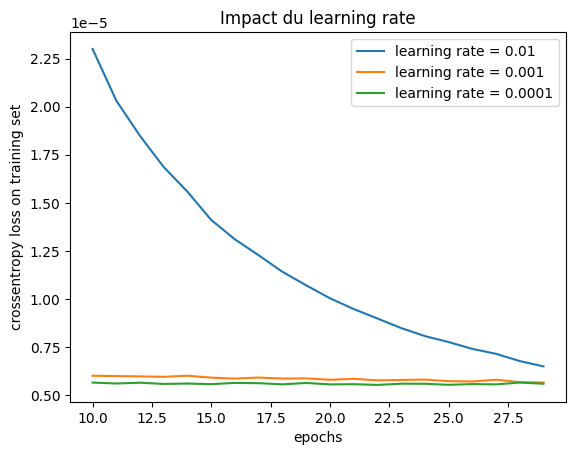

In [ ]:
### Résultats

plt.plot(np.arange(num_epochs)[10:], losses[10:,0], label = 'learning rate = 0.01')
plt.plot(np.arange(num_epochs)[10:], losses[10:,1], label = 'learning rate = 0.001')
plt.plot(np.arange(num_epochs)[10:], losses[10:,2], label = 'learning rate = 0.0001')

#plt.plot(range(num_epochs), losses_test)
plt.xlabel('epochs')
plt.ylabel('crossentropy loss on training set')
plt.title('Impact du learning rate')
plt.legend()


### III.2.3 - Evaluation du modèle sélectionné

Entrainons maintenant le modèle avec un LR = 0.002, sur 200 epochs, avec une taille de mini-batch de 128

In [ ]:

num_epochs = 200
losses = []
losses_test = []
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
### Boucle d'entrainement

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):

  av_loss = 0
  for batch in iterate_minibatches(x_train, y_train, batch_size, True):
    x_batch, y_batch = batch

    optimizer.zero_grad()
    model.train()
    preds = model(x_batch)
    loss = loss_fn(preds, y_batch)
    av_loss += loss.item()
    loss.backward()
    optimizer.step()
  losses.append(av_loss/num_train)
    # Evaluation à chaque epoch
  model.eval()
  preds_test = model(x_test)
  loss_test = loss_fn(preds_test, y_test)
  losses_test.append(loss_test.item())
  print('epoch: ', epoch)


In [ ]:
### Résultats

plt.plot(range(num_epochs), losses)
plt.plot(range(num_epochs), losses_test)
plt.xlabel('epochs')
plt.ylabel('crossentropy loss')
with torch.no_grad():
  preds_test = model(x_test)
  acc = 0
  for i in range(len(y_test)):
    if torch.argmax(preds_test[i]) == y_test[i]:
      acc += 1
  print('test accuracy : {}'.format(acc / len(y_test)))

Prédictions sur l'ensemble de test

In [ ]:
datatest = torch.from_numpy(normalize(prepare_test(dtest)).reshape(-1,1,28,28)).float().to(device)

with torch.no_grad():
  predictions= model(datatest)
  preds = torch.argmax(predictions, axis=1)
  pred = np.array(preds.cpu())
predtest = prepare_output(pred)
print(predtest)
export_output(predtest,'NN_lab9_200_128_nodataaug.csv')

### III.2.4 Data augmentation

Testons l'impact d'ajouter des données transformées à l'ensemble d'entrainement.

In [ ]:
#augment data
x_train, y_train, x_val, y_val = traintest(dx, dy, 0.8, 12)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
x_aug = augment(torch.from_numpy(x_train.reshape(-1,1,28,28)).float())
y_aug = np.concatenate([y_train, y_train,y_train, y_train, y_train], axis= 0)
print(x_aug.shape, y_aug.shape)

(21964, 784) (21964,) (5491, 784) (5491,)
torch.Size([109820, 1, 28, 28]) (109820,)


In [ ]:

torch.manual_seed(12)
torch.cuda.manual_seed(12)
device = torch.device('cuda:0')
x_train = x_aug.to(device)
x_test = torch.from_numpy(x_val.reshape(-1,1,28,28)).float().to(device)
y_train = torch.from_numpy(y_aug).long().to(device)
y_test = torch.from_numpy(y_val).long().to(device)

Réentrainons le CNN sur ces données augmentées

In [ ]:
#ré-entrainons le modèle CNN sur les données augmentées
num_epochs = 200
losses = []
losses_test = []
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
### Boucle d'entrainement

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):

  av_loss = 0
  for batch in iterate_minibatches(x_test, y_test, batch_size, True):
    x_batch, y_batch = batch

    optimizer.zero_grad()
    model.train()
    preds = model(x_batch)
    loss = loss_fn(preds, y_batch)
    av_loss += loss.item()
    loss.backward()
    optimizer.step()
  losses.append(av_loss/num_train)
    # Evaluation à chaque epoch
  model.eval()
  preds_test = model(x_test)
  loss_test = loss_fn(preds_test, y_test)
  losses_test.append(loss_test.item())
  print('epoch: ', epoch)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

test accuracy : 1.0


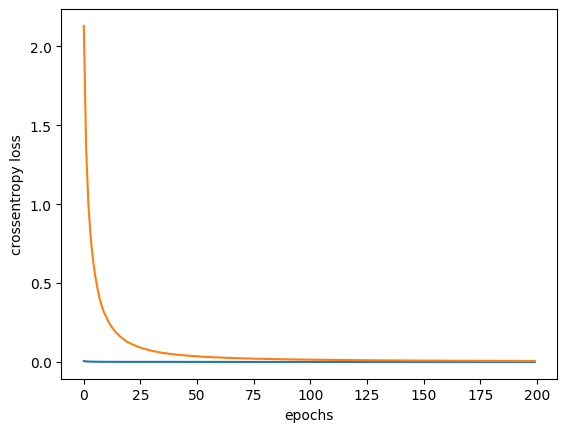

In [ ]:
### Résultats

plt.plot(range(num_epochs), losses)
plt.plot(range(num_epochs), losses_test)
plt.xlabel('epochs')
plt.ylabel('crossentropy loss')
with torch.no_grad():
  preds_test = model(x_test)
  acc = 0
  for i in range(len(y_test)):
    if torch.argmax(preds_test[i]) == y_test[i]:
      acc += 1
  print('test accuracy : {}'.format(acc / len(y_test)))

In [ ]:
# Prédictions sur les données test
datatest = torch.from_numpy(normalize(prepare_test(dtest)).reshape(-1,1,28,28)).float().to(device)

with torch.no_grad():
  predictions= model(datatest)
  preds = torch.argmax(predictions, axis=1)
  pred = np.array(preds.cpu())
predtest = prepare_output(pred)
print(predtest)
export_output(predtest,'NN_lab9_200_128_augRot10_zoomin_zoomout_blur.csv')



# IV - Transfer learning à partir de ResNet50

Testons la technique du transfer learning à partir du réseau ResNet50 préentrainé sur le dataset imagenet. Cette technique permet de pallier le relativment faible nombre de données disponibles specifiques pour notre tache d'entrainement (ASL MNIST dataset), en utilisant un modèle entrainé pour une tache similaire (reconnaissance d'images ) sur un dataset beaucoup plus grand (plus d'1 million de données). Nous modifierons la dernière couche complètement connectée pour adapter le modèle à notre tache de classification (26 classes).   

## IV.1- Formatage des données d'entrée

Nous allons d'abord transformer les images pour les rendre compatibles en taille et en canaux d'entrée avec celles du dataset imagenet. Puis nous les chargeons dans un Tensordataset

On va donc reformater les images, du format (1, 28, 28) à (3, 224, 224)

In [ ]:
x_train, y_train, x_val, y_val = traintest(dx, dy, 0.8, 12)

# resize
x224 = v2.Resize(224)(torch.from_numpy(x_train.reshape(-1,1,28,28)).float())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# resize val data
xval = v2.Resize(224)(torch.from_numpy(x_val.reshape(-1,1,28,28)).float())

In [ ]:
xtrain224 = x224.expand(-1,3,-1,-1)
xval224 = xval.expand(-1,3,-1,-1)
print(xtrain224.shape, xval224.shape)

torch.Size([21964, 3, 224, 224]) torch.Size([5491, 3, 224, 224])


In [ ]:
# transform train and Val datasets into TensorDataset
import torch
from torchvision import models, transforms, datasets
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

train_subset = TensorDataset(xtrain224/255, torch.LongTensor(y_train))
val_subset = TensorDataset(xval224/255, torch.LongTensor(y_val))

In [ ]:
#normalize input data using the same methodology as in ResNet50 paper

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#implementer un dataloader pour entrainer le modèle en utilisant des mini batches
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset,
    batch_size=batch_size,

    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

torch.Size([32, 3, 224, 224]) torch.Size([32])


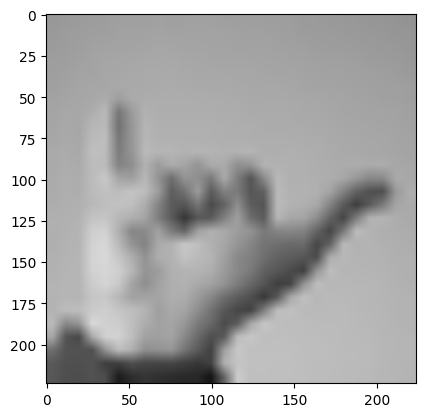

In [ ]:
#cVisualiser une image d'un mini batch
for img, label in train_dataloader:
    print(img.shape, label.shape)
   # print(f'Ground Truth {classes[label[0]]}')
    plt.imshow(img[0].permute(1, 2, 0).numpy().astype(np.uint8))
    break

## IV.2 - Structure du modèle Resnet50 modifié

In [ ]:
# importons le modele ResNet50 préentraine

In [ ]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
#modifier la derniere couche pleinement connectée pour
#l'adapter à notre problème de classification sur 26 classes
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=26)
resnet.fc = fc
resnet



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## IV.3 - Evaluation du modèle

In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    print(name)
    if param.requires_grad == True:
        params_to_update.append(param)

print(params_to_update)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Boucle d'entrainement du modèle resnet50 modifié en utilisant les données d'entrée des images ASL

In [ ]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels.type(torch.LongTensor)

            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels.type(torch.LongTensor)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}')
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')



    return model, train_losses, val_losses



In [ ]:
print_every = 50
num_epoch = 5

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1]/[5]. Batch [50]/[687]. Train loss 2.781. Train acc 22.125. Val loss 2.115. Val acc 47.423. Took 28.310 seconds
Epoch [1]/[5]. Batch [100]/[687]. Train loss 2.285. Train acc 39.938. Val loss 1.443. Val acc 71.135. Took 19.993 seconds
Epoch [1]/[5]. Batch [150]/[687]. Train loss 1.953. Train acc 50.438. Val loss 1.136. Val acc 74.158. Took 19.920 seconds
Epoch [1]/[5]. Batch [200]/[687]. Train loss 1.720. Train acc 57.562. Val loss 0.993. Val acc 76.143. Took 20.205 seconds
Epoch [1]/[5]. Batch [250]/[687]. Train loss 1.549. Train acc 62.025. Val loss 0.865. Val acc 79.257. Took 20.601 seconds
Epoch [1]/[5]. Batch [300]/[687]. Train loss 1.416. Train acc 65.510. Val loss 0.750. Val acc 82.772. Took 21.092 seconds
Epoch [1]/[5]. Batch [350]/[687]. Train loss 1.310. Train acc 68.286. Val loss 0.616. Val acc 86.997. Took 21.561 seconds
Epoch [1]/[5]. Batch [400]/[687]. Train loss 1.221. Train acc 70.586. Val loss 0.578. Val acc 88.345. Took 21.002 seconds
Epoch [1]/[5]. Batch [450

 20%|██        | 1/5 [04:41<18:46, 281.54s/it]

Epoch [2]/[5]. Batch [13]/[687]. Train loss 0.008. Train acc 90.625. Val loss 0.360. Val acc 93.098. Took 17.636 seconds
Epoch [2]/[5]. Batch [63]/[687]. Train loss 0.027. Train acc 94.296. Val loss 0.359. Val acc 92.005. Took 20.995 seconds
Epoch [2]/[5]. Batch [113]/[687]. Train loss 0.044. Train acc 94.248. Val loss 0.331. Val acc 93.134. Took 20.995 seconds
Epoch [2]/[5]. Batch [163]/[687]. Train loss 0.060. Train acc 93.865. Val loss 0.313. Val acc 93.389. Took 21.010 seconds
Epoch [2]/[5]. Batch [213]/[687]. Train loss 0.074. Train acc 94.058. Val loss 0.299. Val acc 93.626. Took 21.049 seconds
Epoch [2]/[5]. Batch [263]/[687]. Train loss 0.084. Train acc 94.237. Val loss 0.295. Val acc 94.245. Took 21.006 seconds
Epoch [2]/[5]. Batch [313]/[687]. Train loss 0.093. Train acc 94.449. Val loss 0.281. Val acc 94.500. Took 21.029 seconds
Epoch [2]/[5]. Batch [363]/[687]. Train loss 0.101. Train acc 94.568. Val loss 0.270. Val acc 94.245. Took 21.009 seconds
Epoch [2]/[5]. Batch [413]

 40%|████      | 2/5 [09:35<14:25, 288.61s/it]

Epoch [3]/[5]. Batch [26]/[687]. Train loss 0.004. Train acc 94.832. Val loss 0.230. Val acc 94.537. Took 19.832 seconds
Epoch [3]/[5]. Batch [76]/[687]. Train loss 0.010. Train acc 96.094. Val loss 0.238. Val acc 94.464. Took 21.012 seconds
Epoch [3]/[5]. Batch [126]/[687]. Train loss 0.016. Train acc 96.007. Val loss 0.204. Val acc 95.884. Took 20.970 seconds
Epoch [3]/[5]. Batch [176]/[687]. Train loss 0.021. Train acc 96.307. Val loss 0.201. Val acc 95.520. Took 20.986 seconds
Epoch [3]/[5]. Batch [226]/[687]. Train loss 0.026. Train acc 96.502. Val loss 0.205. Val acc 95.065. Took 21.043 seconds
Epoch [3]/[5]. Batch [276]/[687]. Train loss 0.030. Train acc 96.581. Val loss 0.182. Val acc 95.957. Took 21.005 seconds
Epoch [3]/[5]. Batch [326]/[687]. Train loss 0.033. Train acc 96.750. Val loss 0.174. Val acc 96.540. Took 20.996 seconds
Epoch [3]/[5]. Batch [376]/[687]. Train loss 0.037. Train acc 96.792. Val loss 0.189. Val acc 95.702. Took 21.009 seconds
Epoch [3]/[5]. Batch [426]

 60%|██████    | 3/5 [14:29<09:42, 291.20s/it]

Epoch [4]/[5]. Batch [39]/[687]. Train loss 0.004. Train acc 94.471. Val loss 0.172. Val acc 95.702. Took 20.238 seconds
Epoch [4]/[5]. Batch [89]/[687]. Train loss 0.007. Train acc 95.997. Val loss 0.144. Val acc 96.922. Took 21.001 seconds
Epoch [4]/[5]. Batch [139]/[687]. Train loss 0.010. Train acc 96.875. Val loss 0.160. Val acc 95.957. Took 21.064 seconds
Epoch [4]/[5]. Batch [189]/[687]. Train loss 0.012. Train acc 97.222. Val loss 0.155. Val acc 96.321. Took 21.020 seconds
Epoch [4]/[5]. Batch [239]/[687]. Train loss 0.014. Train acc 97.333. Val loss 0.162. Val acc 95.720. Took 21.000 seconds
Epoch [4]/[5]. Batch [289]/[687]. Train loss 0.016. Train acc 97.578. Val loss 0.141. Val acc 96.758. Took 20.995 seconds
Epoch [4]/[5]. Batch [339]/[687]. Train loss 0.018. Train acc 97.668. Val loss 0.132. Val acc 97.232. Took 21.016 seconds
Epoch [4]/[5]. Batch [389]/[687]. Train loss 0.020. Train acc 97.710. Val loss 0.134. Val acc 97.013. Took 20.978 seconds
Epoch [4]/[5]. Batch [439]

 80%|████████  | 4/5 [19:07<04:45, 285.95s/it]

Epoch [5]/[5]. Batch [2]/[687]. Train loss 0.000. Train acc 98.438. Val loss 0.119. Val acc 97.432. Took 16.485 seconds
Epoch [5]/[5]. Batch [52]/[687]. Train loss 0.002. Train acc 98.317. Val loss 0.132. Val acc 96.868. Took 21.017 seconds
Epoch [5]/[5]. Batch [102]/[687]. Train loss 0.003. Train acc 98.376. Val loss 0.113. Val acc 97.687. Took 20.998 seconds
Epoch [5]/[5]. Batch [152]/[687]. Train loss 0.005. Train acc 98.684. Val loss 0.121. Val acc 97.268. Took 20.989 seconds
Epoch [5]/[5]. Batch [202]/[687]. Train loss 0.006. Train acc 98.623. Val loss 0.128. Val acc 96.868. Took 21.001 seconds
Epoch [5]/[5]. Batch [252]/[687]. Train loss 0.007. Train acc 98.512. Val loss 0.105. Val acc 97.833. Took 21.330 seconds
Epoch [5]/[5]. Batch [302]/[687]. Train loss 0.009. Train acc 98.520. Val loss 0.112. Val acc 97.432. Took 20.986 seconds
Epoch [5]/[5]. Batch [352]/[687]. Train loss 0.010. Train acc 98.580. Val loss 0.116. Val acc 97.177. Took 21.066 seconds
Epoch [5]/[5]. Batch [402]/

100%|██████████| 5/5 [24:01<00:00, 288.21s/it]


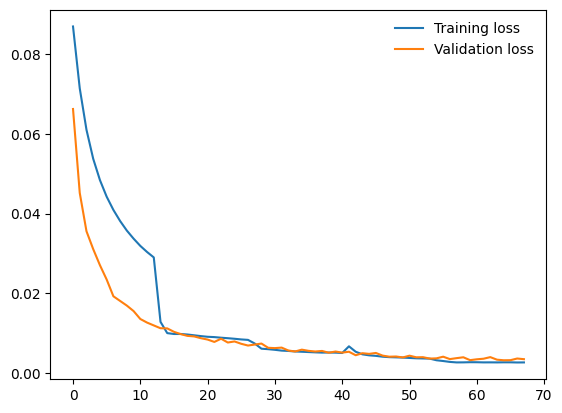

In [ ]:
#résultats
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
#Predictions sur les données tests
torch.cuda.empty_cache()
datatest = torch.from_numpy(prepare_test(dtest).reshape(-1,1,28,28)).float()

#redimesionner les données test pour qu'elles soient au format attendu (imagenet)
data = v2.Resize(224)(datatest).expand(-1,3,-1,-1)/255

print(data.shape)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([6000, 3, 224, 224])


In [ ]:
#charger les données tests préparées dans un dataloader
test_subset = TensorDataset(data,data)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_subset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# Predictions sur les données test
prediction = torch.empty((0), dtype=torch.long).to(device)
with torch.no_grad(): # save some co
  resnet.eval()

  for images, lab in test_dataloader:
    images = images.to(device)
    output = resnet(images)
    preds = torch.argmax(output, axis=1)
    prediction = torch.cat((prediction,preds),axis=0)
  pred = np.array(prediction.cpu())



In [ ]:
# exporter les résultats de test et mise au format des outputs
print(pred.shape)
predtest = prepare_output(pred)
print(predtest.shape)
export_output(predtest,'resNet50_nodataaug_5epochs.csv')


(6000,)
(3000,) (3000,)
[ 77  90  71 ... 109  83  98]
(3000,)
